In [42]:
import torch
import torchvision
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import cv2

In [2]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [3]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'masks': tensor([], size=(0, 1, 300, 400))},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'masks': tensor([], size=(0, 1, 500, 400))}]

In [119]:
import pyrealsense2 as rs
import numpy as np
## define path to bag
bag_path = '/home/richard/realsense_workshop/day_1_pm/resources/table2.bag'

# Create pipeline
pipeline = rs.pipeline()
# Create a config object
config = rs.config()
# Tell config that we will use a recorded device from file to be used by the pipeline through playback.
rs.config.enable_device_from_file(config, bag_path)

# pipeline_wrapper = rs.pipeline_wrapper(pipeline)
# pipeline_profile = config.resolve(pipeline_wrapper)
# Configure the pipeline to stream the depth stream
# Change this parameters according to the recorded bag file resolution
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 15)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 15)

# pipeline would not resolve if the config does not match or if the config is not possible
profile = pipeline.start(config)

depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()

# the depth scale is the multiplier to the number that the 

align_to = rs.stream.color
align = rs.align(align_to)

# Create opencv window to render image in

# Create colorizer object
colorizer = rs.colorizer()

pc = rs.pointcloud()

In [120]:
frames = pipeline.wait_for_frames()
# frames.get_depth_frame() is a 640x360 depth image

# Align the depth frame to color frame
aligned_frames = align.process(frames)

# Get aligned frames
aligned_depth_frame = aligned_frames.get_depth_frame() # aligned_depth_frame is a 640x480 depth image
color_frame = aligned_frames.get_color_frame()

# Validate that both frames are valid
if not aligned_depth_frame or not color_frame:
    pass

depth_image = np.asarray(aligned_depth_frame.get_data())
color_image = np.asarray(color_frame.get_data())

points = pc.calculate(aligned_depth_frame)
pc.map_to(color_frame)

In [131]:
v, t = points.get_vertices(), points.get_texture_coordinates()
verts = np.asanyarray(v).view(np.float32).reshape(480, 640, 3)  # xyz
texcoords = np.asanyarray(t).view(np.float32).reshape(480, 640, 2)  # uv

In [101]:
pipeline.stop()

In [121]:
import matplotlib.pyplot as plt

In [122]:
from PIL import Image
from torchvision import transforms as T
import numpy as np

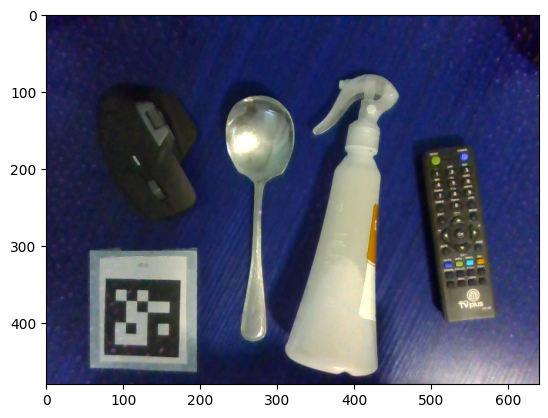

In [123]:
plt.imshow(color_image)

In [124]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# I will link the notebook in the description
# You can copy the class names from the description
# or the notebook
len(COCO_INSTANCE_CATEGORY_NAMES) # 91 classes including background

91

In [125]:
def get_prediction(img, threshold=0.5):
  transform = T.Compose([T.ToTensor()]) # Turn the image into a torch.tensor
  img = transform(img)
  # img = img.cuda() # Only if GPU, otherwise comment this line
  pred = model([img]) # Send the image to the model. This runs on CPU, so its going to take time
  #Let's change it to GPU
  # pred = pred.cpu() # We will just send predictions back to CPU
  # Now we need to extract the bounding boxes and masks
  pred_score = list(pred[0]['scores'].detach().cpu().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
  masks = (pred[0]['masks'] > 0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

In [126]:
# for generating random color for the masks

import random

def random_color_masks(image):
  # I will copy a list of colors here
  colors = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180], [250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image==1], g[image==1], b[image==1] = colors[random.randrange(0, 10)]
  colored_mask = np.stack([r,g,b], axis=2)
  return colored_mask

In [149]:
def instance_segmentation(img, threshold=0.5, rect_th=3,
                          text_size=1, text_th=1, url=False):
  masks, boxes, pred_cls = get_prediction(img, threshold=threshold)
    
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # For working with RGB images instead of BGR
  for i in range(len(masks)):
    rgb_mask = random_color_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    pt1 = tuple(int(x) for x in boxes[i][0])
    pt2 = tuple(int(x) for x in boxes[i][1])
    cv2.rectangle(img, pt1, pt2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img, pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th)
  return img, pred_cls, masks, boxes

In [150]:
img, pred_classes, masks, boxes = instance_segmentation(color_image, rect_th=1, text_th=1)

In [151]:
boxes

[[(np.float32(238.04579), np.float32(104.20558)),
  (np.float32(317.20972), np.float32(427.43585))],
 [(np.float32(484.34384), np.float32(171.42346)),
  (np.float32(585.9372), np.float32(398.72382))],
 [(np.float32(317.9652), np.float32(73.509964)),
  (np.float32(458.37985), np.float32(480.00003))]]

In [129]:
#check the predicted classes
pred_classes

['spoon', 'remote', 'toothbrush']

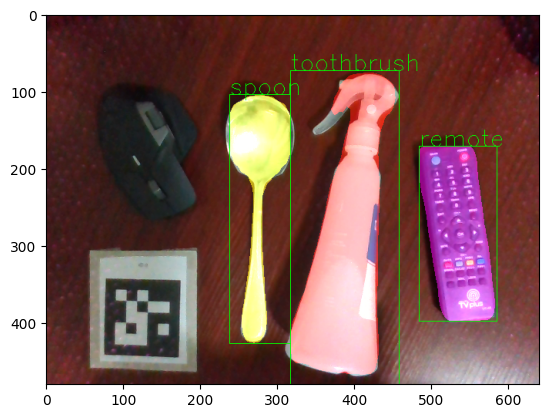

In [130]:
plt.imshow(img)

In [79]:
img = color_image

In [116]:
# check the image by masking
img[~masks[0],:] = [0,0,0]

In [134]:
verts.shape

(480, 640, 3)

In [146]:
img_points = verts[masks[0],:]

In [147]:
img_points.shape

(11799, 3)

In [145]:
img_points[:,2].max()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

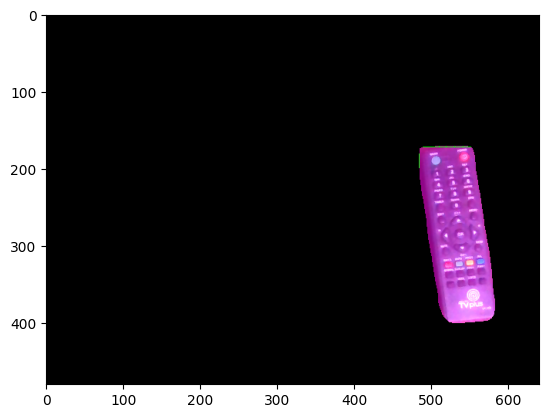

In [117]:
plt.imshow(img)

In [82]:
depth_image

array([[  0,   0,   0, ..., 868, 867, 867],
       [  0,   0,   0, ..., 869, 868, 867],
       [  0,   0,   0, ..., 869, 868, 867],
       ...,
       [  0,   0,   0, ..., 391, 390, 390],
       [  0,   0,   0, ..., 390, 390, 390],
       [  0,   0,   0, ..., 390, 390, 390]], dtype=uint16)